In [ ]:
!pip install transformers==2.4.0

In [2]:
# importing necessary libraries
from typing import List, Tuple
import random
import html

import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, KFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow.keras.backend as K
import os
from scipy.stats import spearmanr
from scipy.optimize import minimize
from math import floor, ceil
from transformers import *
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model

In [3]:
# fixing random seeds
seed = 13
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# reading the data into dataframe using pandas
train = pd.read_csv('drive/My Drive/case_study_2/train.csv')
test = pd.read_csv('drive/My Drive/case_study_2/test.csv')
submission = pd.read_csv('drive/My Drive/case_study_2/sample_submission.csv')

In [7]:
# Selecting data for training and testing
y = train[train.columns[11:]] # storing the target values in y
X = train[['question_title', 'question_body', 'answer']]
X_test = test[['question_title', 'question_body', 'answer']]

In [8]:
# Cleaning the data
X.question_body = X.question_body.apply(html.unescape)
X.question_title = X.question_title.apply(html.unescape)
X.answer = X.answer.apply(html.unescape)

X_test.question_body = X_test.question_body.apply(html.unescape)
X_test.question_title = X_test.question_title.apply(html.unescape)
X_test.answer = X_test.answer.apply(html.unescape)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
# this function trims the tokens with length > 512 to match with the bert input.
def _trim_input(tokens, max_sequence_length=512):
    length = len(tokens)
    if length > max_sequence_length:
      tokens = tokens[:max_sequence_length-1]
    return tokens

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_SEQUENCE_LENGTH = 512

# function for tokenizing the input data for bert
def _convert_to_transformer_inputs(title, question, answer, tokenizer):
    question = f"{title} [SEP] {question}"
    question_tokens = tokenizer.tokenize(question)
    answer_tokens = tokenizer.tokenize(answer)
    question_tokens = _trim_input(question_tokens)
    answer_tokens = _trim_input(answer_tokens)
    ids_q = tokenizer.convert_tokens_to_ids(["[CLS]"] + question_tokens)
    ids_a = tokenizer.convert_tokens_to_ids(["[CLS]"] + answer_tokens)
    padded_ids_q = (ids_q + [tokenizer.pad_token_id] * (MAX_SEQUENCE_LENGTH - len(ids_q)))[:MAX_SEQUENCE_LENGTH]
    padded_ids_a = (ids_a + [tokenizer.pad_token_id] * (MAX_SEQUENCE_LENGTH - len(ids_a)))[:MAX_SEQUENCE_LENGTH]
    token_type_ids_q = ([0] * MAX_SEQUENCE_LENGTH)[:MAX_SEQUENCE_LENGTH]
    token_type_ids_a = ([0] * MAX_SEQUENCE_LENGTH)[:MAX_SEQUENCE_LENGTH]
    attention_mask_q = ([1] * len(ids_q) + [0] * (MAX_SEQUENCE_LENGTH - len(ids_q)))[:MAX_SEQUENCE_LENGTH]
    attention_mask_a = ([1] * len(ids_a) + [0] * (MAX_SEQUENCE_LENGTH - len(ids_a)))[:MAX_SEQUENCE_LENGTH]
    
    return (padded_ids_q, padded_ids_a, token_type_ids_q, token_type_ids_a, attention_mask_q, attention_mask_a)

In [11]:
# function for creating the input_ids, masks and segments for the bert input
def compute_input_arrays(df, question_only=False):
    input_ids_q, input_token_type_ids_q, input_attention_masks_q = [], [], []
    input_ids_a, input_token_type_ids_a, input_attention_masks_a = [], [], []
    i=0
    for title, body, answer in zip(df["question_title"].values, df["question_body"].values, df["answer"].values):
        values = _convert_to_transformer_inputs(title, body, answer, tokenizer)
        padded_ids_q, padded_ids_a, token_type_ids_q, token_type_ids_a, attention_mask_q, attention_mask_a = values
        input_ids_q.append(padded_ids_q)
        input_ids_a.append(padded_ids_a)
        input_token_type_ids_q.append(token_type_ids_q)
        input_token_type_ids_a.append(token_type_ids_a)
        input_attention_masks_q.append(attention_mask_q)
        input_attention_masks_a.append(attention_mask_a)
        i+=1

    return (np.asarray(input_ids_q, dtype=np.int32),
            np.asarray(input_ids_a, dtype=np.int32),
            np.asarray(input_token_type_ids_q, dtype=np.int32),
            np.asarray(input_token_type_ids_a, dtype=np.int32),
            np.asarray(input_attention_masks_q, dtype=np.int32),
            np.asarray(input_attention_masks_a, dtype=np.int32))

def compute_output_arrays(df):
    return np.asarray(df[output_categories])

In [5]:
# Creating the model
K.clear_session()
max_seq_length = 512

input_tokens = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_tokens")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
input_segment = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_segment")

#bert layer
bert_config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=bert_config)

sequence_output, pooler_output, hidden_states = bert_model([input_tokens,input_mask, input_segment])
# Last 4 hidden layers of bert
h12 = tf.reshape(hidden_states[-1][:,0],(-1,1,768))
h11 = tf.reshape(hidden_states[-2][:,0],(-1,1,768))
h10 = tf.reshape(hidden_states[-3][:,0],(-1,1,768))
h09 = tf.reshape(hidden_states[-4][:,0],(-1,1,768))
concat_hidden = tf.keras.layers.Concatenate(axis=2)([h12, h11, h10, h09])

x = GlobalAveragePooling1D()(concat_hidden)

output = Dense(21, activation='sigmoid')(x)

model_q = Model(inputs=[input_tokens, input_mask, input_segment], outputs=output)

In [6]:
model_q.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_tokens (InputLayer)       [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_segment (InputLayer)      [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 512, 768), ( 109482240   input_tokens[0][0]               
                                                                 input_mask[0][0]             

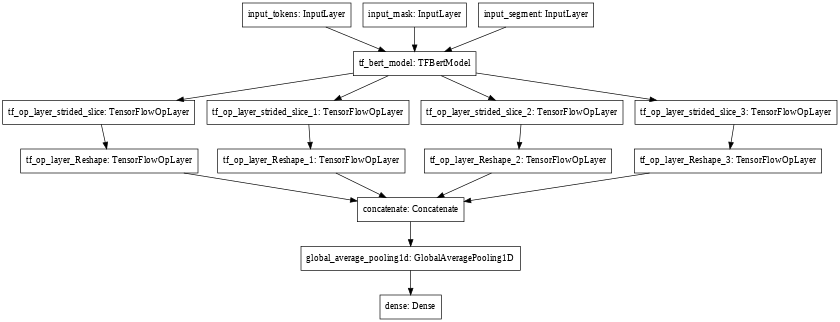

In [7]:
tf.keras.utils.plot_model( 
    model_q, to_file='model.png', 
    show_shapes=False, 
    show_layer_names=True, 
    rankdir='TB', 
    expand_nested=False, dpi=48
)

In [15]:
# Train data
tokens_q, tokens_a, segments_q, segments_a, masks_q, masks_a = compute_input_arrays(X)
train_data_q = {'input_tokens': tokens_q, 
              'input_mask': masks_q, 
              'input_segment': segments_q}

# Test data
tokens_q, tokens_a, segments_q, segments_a, masks_q, masks_a = compute_input_arrays(X_test)
test_data_q = {'input_tokens': tokens_q, 
             'input_mask': masks_q, 
             'input_segment': segments_q} 

In [16]:
# Function to calculate the Spearman's rank correlation coefficient 'rhos' of actual and predicted data.
from scipy.stats import spearmanr
def compute_spearmanr_ignore_nan(trues, preds):
    rhos = []
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
        rhos.append(spearmanr(tcol, pcol).correlation)
    return np.nanmean(rhos)

In [17]:
# Making the 'rhos' metric to tensorflow graph compatible.
def rhos(y, y_pred):
  return tf.py_function(compute_spearmanr_ignore_nan, (y, y_pred), tf.double)
metrics = [rhos]

In [19]:
# Target values for question
y_train_q = y.values[:,:21]

In [20]:
# Compiling and training the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002)
model_q.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)
for i in range(1):
  model_q.fit(train_data_q, y_train_q, epochs=1, batch_size=4, validation_split=0.1)
  model.save_weights("drive/My Drive/model_q.h5")

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


1368/1368 [==============================] - 748s 547ms/step - loss: 0.3879 - rhos: 0.3888 - val_loss: 0.3660 - val_rhos: 0.4439


In [27]:
model_q.fit(train_data_q, y_train_q, epochs=1, batch_size=4)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


1520/1520 [==============================] - 804s 529ms/step - loss: 0.3393 - rhos: 0.5543


In [29]:
# Predicting the train and test data labels
pred_q_test = model_q.predict(test_data_q)
pred_q_train = model_q.predict(train_data_q)

# saving the predicted labels as dataframes
df = pd.DataFrame(pred_q_train, columns=y.columns[:21])
df.to_csv('pred_q_train.csv', index=False)

df = pd.DataFrame(pred_q_test, columns=y.columns[:21])
df.to_csv('pred_q_test.csv', index=False)